k/kcrit = 0.1000
Simulation completed and data saved.
Created plots showing shear stress, slip rate, and state variable over time.
Saved data for later use with SINDy.


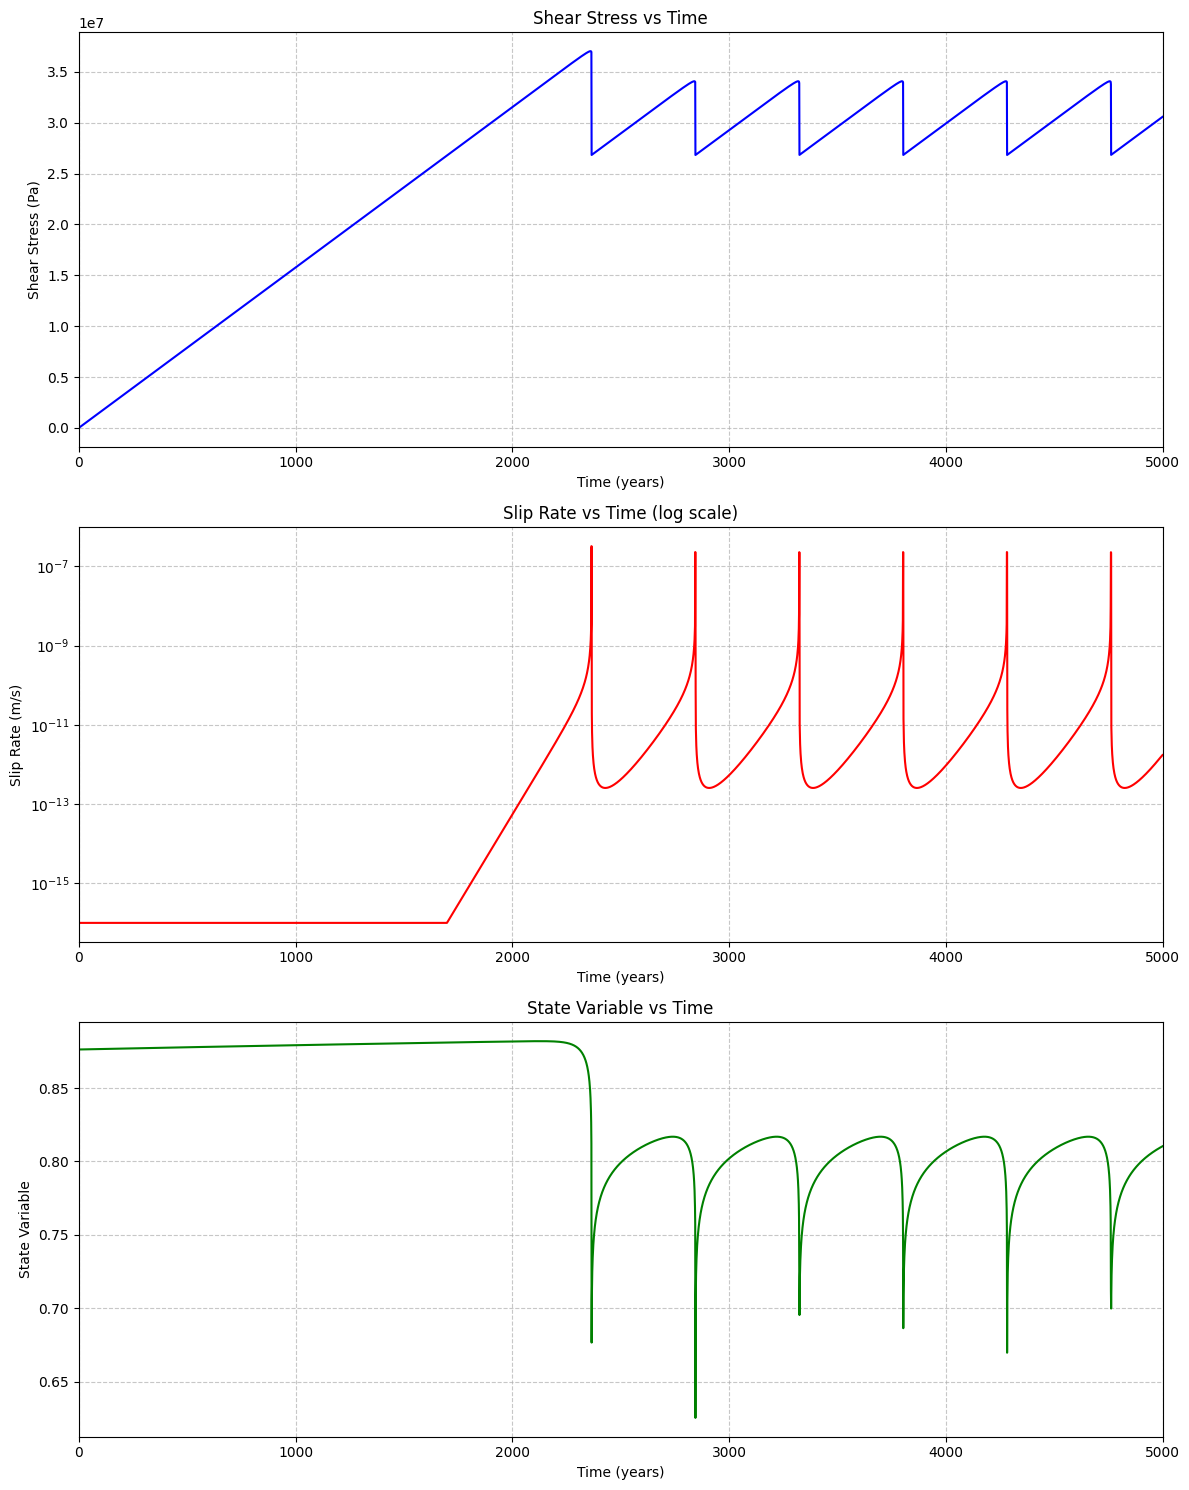

In [1]:
import numpy as np
from scipy.optimize import fsolve
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Material parameters - using original values from the notebook
sm = 3e10                  # Shear modulus (Pa)
density = 2700             # rock density (kg/m^3)
cs = np.sqrt(sm / density) # Shear wave speed (m/s)
eta = sm / (2 * cs)        # Radiation damping coefficient
L = 60 * 1000              # Width of plate boundary (m)
k = sm / L                 # spring constant (Pa / m)
Vp = 1e-9                  # Rate of plate motion

# Friction parameters - original values that show stick-slip
sigma_n = 50e6   # Normal stress (Pa)
a = 0.015        # direct velocity strengthening effect
b = 0.02         # state-based velocity weakening effect
Dc = 0.2         # state evolution length scale (m)
f0 = 0.6         # baseline coefficient of friction
V0 = 1e-6        # reference velocity (m/s)

# Check stability criterion
kcrit = sigma_n * b / Dc 
print(f'k/kcrit = {k/kcrit:.4f}')

# Define friction and state evolution laws
def F(V, sigma_n, state):
    """Rate-state friction law with Rice regularization"""
    f = a * np.arcsinh(V / (2 * V0) * np.exp(state / a))
    return f * sigma_n

def G(V, state):
    """State evolution law (aging law)"""
    return (b * V0 / Dc) * (np.exp((f0 - state) / b) - (V / V0))

def steady_state(V_slider):
    """Calculate steady-state value of state variable"""
    def f(state):
        return G(V_slider, state)
    return fsolve(f, 0.0)[0]

# Initial conditions
x_0 = 0.0                  # Initial position
V_slider_0 = Vp / 1000.0   # Initial velocity (slower than loading rate)
state_0 = steady_state(V_slider_0)  # Initial state
initial_conditions = [x_0, state_0]

# Function to solve for velocity at each time step
def current_vel(tau_qs, state, V_slider_old):
    """Solve for current velocity given traction"""
    def f(V):
        return tau_qs - eta * V - F(V, sigma_n, state)
    return fsolve(f, V_slider_old)[0]

# ODE system for the block slider model
def f(x_and_state, t):
    """ODE function for block slider system"""
    x, state = x_and_state
    # Calculate loading point position
    y = Vp * t
    # Calculate spring force
    tau_qs = k * (y - x)
    # Solve for velocity
    V_slider = current_vel(tau_qs, state, f.V_slider_old)
    # Store velocity for next iteration
    f.V_slider_old = V_slider
    # Return derivatives
    dxdt = V_slider
    dstatedt = G(V_slider, state)
    return [dxdt, dstatedt]

# Initialize velocity history
f.V_slider_old = V_slider_0

# Generate time points - simulate for 5000 years to capture multiple cycles
secs_per_year = 365 * 24 * 60 * 60
years = 5000
num_points = 5001  # Higher resolution for capturing stick-slip
t_years = np.linspace(0, years, num_points)
t = t_years * secs_per_year

# Solve the ODE system with tight tolerances
history = odeint(f, initial_conditions, t, rtol=1e-12, atol=1e-12, mxstep=5000)
x_data = history[:, 0]
state_data = history[:, 1]

# Calculate derived variables
y_load = t * Vp
tau_data = k * (y_load - x_data)  # Shear stress

# Calculate velocity using central differences
v_data = np.zeros_like(x_data)
v_data[1:-1] = (x_data[2:] - x_data[:-2]) / (t[2:] - t[:-2])
v_data[0] = (x_data[1] - x_data[0]) / (t[1] - t[0])
v_data[-1] = (x_data[-1] - x_data[-2]) / (t[-1] - t[-2])
v_data = np.clip(v_data, V0 * 1e-10, None)  # Ensure positive velocity

# Find a detailed portion showing clear stick-slip behavior
# Look for peaks in slip rate

# Create a three-panel plot showing just the three key variables
plt.figure(figsize=(12, 15))

# 1. Shear Stress
plt.subplot(311)
plt.plot(t_years, tau_data, 'b-', linewidth=1.5)
plt.xlim(0,5000)
plt.xlabel('Time (years)')
plt.ylabel('Shear Stress (Pa)')
plt.title('Shear Stress vs Time')
plt.grid(True, linestyle='--', alpha=0.7)

# 2. Slip Rate (velocity)
plt.subplot(312)
plt.semilogy(t_years,v_data,'r-',linewidth=1.5)
plt.xlabel('Time (years)')
plt.ylabel('Slip Rate (m/s)')
plt.title('Slip Rate vs Time (log scale)')
plt.xlim(0,5000)
plt.grid(True, linestyle='--', alpha=0.7)

# 3. State Variable
plt.subplot(313)
plt.plot(t_years,state_data,'g-',linewidth=1.5)
plt.xlabel('Time (years)')
plt.ylabel('State Variable')
plt.title('State Variable vs Time')
plt.xlim(0,5000)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig('block_slider_three_variables.png', dpi=300)

# Prepare data for SINDy (but don't run SINDy yet)
# Create feature matrix X with [x, v, state, tau]
X = np.column_stack((x_data, v_data, state_data, tau_data))

# Save data to file for later use with SINDy
np.save('block_slider_data.npy', X)
np.save('block_slider_time.npy', t)

print("Simulation completed and data saved.")
print("Created plots showing shear stress, slip rate, and state variable over time.")
print("Saved data for later use with SINDy.")

In [2]:
np.save('../data/block_slider_data.npy', X)
np.save('../data/block_slider_time.npy', t)